In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
import os
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/ML_rruff/BackUps'
os.chdir(data_dir)

# List the contents of the directory
!ls

10e2_run1.pth  data_tensor.pt  label_indices.pt  labels.pt  label_to_index.pt  Model_DB.gdoc  Test1


In [4]:
label_to_index = torch.load('label_to_index.pt')
data_tensor = torch.load('data_tensor.pt')
labels = torch.load('labels.pt')
label_indices = torch.load('label_indices.pt')

In [9]:
class NN(torch.nn.Module):
    def __init__(self, label_to_index):
        super().__init__()
        self.g = torch.Generator().manual_seed(2147483647)

        self.W1 = torch.nn.Parameter(torch.randn((8501, 4000), generator=self.g))
        self.b1 = torch.nn.Parameter(torch.randn(4000, generator=self.g))
        self.W2 = torch.nn.Parameter(torch.randn((4000, 1500), generator=self.g))
        self.b2 = torch.nn.Parameter(torch.randn(1500, generator=self.g))
        self.W3 = torch.nn.Parameter(torch.randn((1500, len(label_to_index)), generator=self.g))
        self.b3 = torch.nn.Parameter(torch.randn(len(label_to_index), generator=self.g))

        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def forward(self, data_tensor, label_indices):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        h2 = torch.tanh(h @ self.W2 + self.b2)
        logits = h2 @ self.W3 + self.b3
        probabilities = F.softmax(logits, dim=1)

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(logits, label_indices)

        return loss

    def __call__(self, data_tensor):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        h2 = torch.tanh(h @ self.W2 + self.b2)
        logits = h2 @ self.W3 + self.b3
        probabilities = F.softmax(logits, dim=0)

        return probabilities

nn_model = NN(label_to_index)
nn_model.load_state_dict(torch.load('10e2_run1.pth'))
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.1)

nn_model = nn_model.to('cuda')
data_tensor = data_tensor.to('cuda')
label_indices = label_indices.to('cuda')


The NN has: 41144256 parameters


Expected label:  Diopside
Predicted label: Diopside
Probability: 1.0000


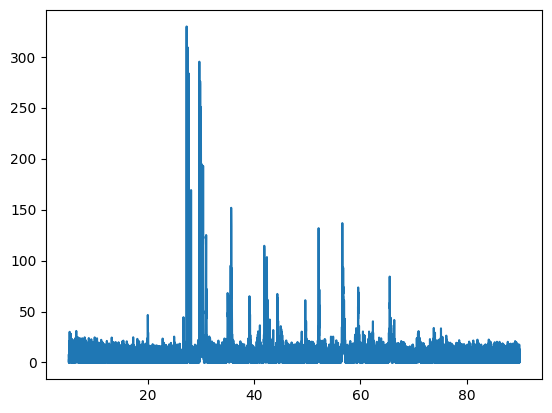

(1.0, True)

In [17]:

index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the dictionary
def test_example(data_tensor, i, p_info=True):

  probabilities = nn_model(data_tensor[i])

  max_prob_index = torch.argmax(probabilities).item()

  predicted_label = index_to_label[max_prob_index]
  if p_info == True:
    #print(data_tensor[i])
    print(f"Expected label:  {index_to_label[label_indices[i].item()]}")
    print(f"Predicted label: {predicted_label}")
    print(f"Probability: {probabilities[max_prob_index].item():.4f}")

    plt.plot(np.arange(5, 90.01, 0.01), data_tensor[i].cpu())
    plt.show()


  return probabilities[max_prob_index].item(), index_to_label[label_indices[i].item()] == predicted_label

test_example(data_tensor, 100)